# Flow-Matching Posterior Estimation (FMPE) and Neural Posterior Score Estimation (NPSE)

`sbi` also incorporates recent algorithms based on Flow Matching and Score Matching generative models, which are also referred to as Continuous Normalizing Flows (CNF) and Denoising Diffusion Probabilistic Models (DDPM), respectively.

At the highest level, you can conceptualize FMPE and NPSE as tackling the exact same problem as NPE, i.e., estimating the posterior from simulations, but replacing Normalizing Flows with different conditional density estimators. 

Flow Matching and Score Matching, as generative models, are also quite similar to Normalizing Flows, where a deep neural network parameterizes the transformation from a base distribution (e.g., Gaussian) to a more complex one that approximates the target density, but they differ in what this transformation looks like (more on that below). 

Beyond that, Flow Matching and Score Matching offer different benefits and drawbacks compared to Normalizing Flows, which make them better (or worse) choices for some problems. For examples, Score Matching (Diffusion Models) are known to be very flexible and can model high-dimensional distributions, but are comparatively slow during sampling.

In this tutorial, we take a brief look at the API for `FMPE` and `NPSE`, their pros and cons, as well as highlight some notable options.

For more information, see:

**Score Matching**:
- Hyvärinen, A. "Estimation of Non-Normalized Statistical Models by Score Matching." JMLR 2005.
- Song, Y., et al. "Score-Based Generative Modeling through Stochastic Differential Equations." ICLR 2021.
- Geffner, T., Papamakarios, G., and Mnih, A. "Score modeling for simulation-based inference." NeurIPS 2022 Workshop on Score-Based Methods. 2022.
- Sharrock, L., Simons, J., et al. "Sequential neural score estimation: Likelihood-free inference with conditional score based diffusion models." ICML 2024.

**Flow Matching**:
- Lipman, Y., et al. "Flow Matching for Generative Modeling." ICLR 2023
- Wildberger, J.B.,  Buchholz, S., et al. "Flow Matching for Scalable Simulation-Based Inference." NeurIPS 2023.

In [2]:
! pip install sbi

import torch

from sbi.inference import NPSE
from sbi.utils import BoxUniform
from sbi.analysis import pairplot
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

  Using cached arviz-0.20.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached pyknos-0.16.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached pyro_ppl-1.9.1-py3-none-any.whl.metadata (7.8 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached zuko-1.3.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached nflows-0.14.tar.gz (45 kB)
  Preparing metadata (setup.py) ... done
  Using cached xarray_einstats-0.8.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached pyro_api-0.1.2-py3-none-any.whl.metadata (2.5 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached etuples-0.3.9.tar.gz (30 kB)
  Preparing metadata (setup.py) ... done
  Using cached logical-unification-0.4.6.tar.gz (31 kB)
  Preparing metadata (setup.py) ... done
  U

In [42]:
num_dim = 2

def sample_model_parameters():
    # Sample from distributions
    G_frame = torch.normal(8.5, 0.3, size=(1,))  # Normal distribution for G_frame
    poro = torch.normal(0.37, 0.02, size=(1,))   # Normal distribution for porosity
    rho_grain = torch.normal(44.8, 0.8, size=(1,))  # Normal distribution for rho_grain

    # Combine into a vector
    m = torch.cat((G_frame, poro, rho_grain))
    return m

def simulator(theta):
    max_attempts = 1000  # Set the maximum number of attempts to find valid parameters
    #print(theta.shape)
    for attempt in range(max_attempts):
        m = sample_model_parameters()  # Resample `m` each attempt for independence

        # Calculate the denominator
        denominator = (theta * (1 - m[1])) + (m[1] * m[2])

        # Check if all values in denominator are positive
        if torch.all(denominator > 0):
            # Valid denominator found, compute simulated data
            simulated_data = torch.sqrt(m[0] / denominator)
            return simulated_data.view(2)
        else:
            # Debug: Print values if denominator is invalid
            print(f"Attempt {attempt + 1}: Invalid denominator values {denominator}")
            #print(f"theta = {theta}, m[0] = {m[0]}, m[1] = {m[1]}, m[2] = {m[2]}")

    # If all attempts failed, return NaNs and print a debug message
    print("Warning: All attempts to find a valid denominator failed.")
    return torch.tensor([float('nan'), float('nan')])

# def simulator(x):
#     """
#     Forward model with resampling of parameters until all denominator values > 0.

#     Args:
#         x (torch.Tensor): Input tensor for the model.
#         max_attempts (int): Maximum attempts to resample valid parameters (unused here but kept for compatibility).

#     Returns:
#         torch.Tensor: Synthetic data, with NaN if denominator is invalid.
#     """
#     # Initialize synthetic values
#     synthetic_value = torch.zeros_like(x)  # Placeholder for synthetic values

#     # Fixed deterministic parameters
#     G_frame_values = torch.tensor([7.994777040351033, 7.997586766477148], device=x.device)
#     poro = 0.3700000000000001
#     rho_grain = 44.8

#     # Iterate over each element in x
#     for i in range(x.size(0)):
#         # Use modulo to wrap around G_frame_values if x has more elements
#         G_frame = G_frame_values[i % len(G_frame_values)]

#         # Compute the denominator
#         denominator = (x[i] * (1 - poro)) + (poro * rho_grain)


#         synthetic_value[i] = torch.sqrt(G_frame / denominator)

#     return synthetic_value



# Define the prior
prior = BoxUniform(low=0.01 * torch.ones(num_dim), high=10 * torch.ones(num_dim))

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [43]:
# Example toy simulator
# Define the prior
num_dims = 2
num_sims = 2000
#prior = BoxUniform(low=-torch.ones(num_dims), high=torch.ones(num_dims))

# def simulator(theta):
#     """Linear gaussian simulator."""
#     return theta + 1.0 + torch.randn_like(theta) * 0.1

# Produce simulations
theta = prior.sample((num_sims,))
x = simulator(theta)
print(x)

# theta_o = torch.zeros(num_dims)
# x_o = simulator(theta_o)

tensor([[0.6755, 0.7101],
        [0.6919, 0.6112],
        [0.6347, 0.6060],
        ...,
        [0.7311, 0.7276],
        [0.6917, 0.6141],
        [0.6968, 0.6833]])


## FMPE

Flow-Matching Posterior Estimation (FMPE) is an approach to Simulation-Based Inference
(SBI) that leverages Flow Matching, a generative modeling technique where the
transformation from a simple base distribution (like a Gaussian) to the target
distribution is learned through matching the flow of probability densities.

### Key Concept:
- **Flow Matching**: The core idea is to model the probability flow between the base
  distribution and the target distribution by minimizing a discrepancy between their
  "flows" or "dynamics" in the latent space. This is typically done by training a neural
  network to parameterize a vector field that defines how samples should be moved or
  transformed in order to follow the target distribution.

### Step-by-Step Process:
1. **Base Distribution**: Start with a simple base distribution (e.g., Gaussian).
2. **Neural Network Parameterization**: Use a neural network to learn a vector field
   that describes the flow from the base distribution to the target distribution.
3. **Flow Matching Objective**: Optimize the neural network to minimize a loss function
   that captures the difference between the flow of the base distribution and the target
   distribution.
4. **Sampling**: Once trained, draw samples from the base distribution and apply the
   learned flow transformation to obtain samples from the approximate posterior
   distribution.

FMPE can be more efficient than traditional normalizing flows in some settings,
especially when the target distribution has complex structures or when high-dimensional
data is involved (see Dax et al., 2023, https://arxiv.org/abs/2305.17161 for an
example). However, compared to (discrete time) normalizing flows, flow matching is
usually slower at inference time because sampling and evaluation of the target
distribution requires solving the underlying ODE (compared to just doing a NN forward
pass for normalizing flows). 

In the next cell, we'll show how to use FMPE using the `sbi` package.



In [44]:
from sbi.inference import FMPE
from sbi.neural_nets import flowmatching_nn

theta_true = torch.tensor([[4, 7]])
# generate our observation
x_obs = torch.tensor([0.64704126, 0.61732611])  # Provided observed data
# the quick way

trainer = FMPE(prior)
trainer.append_simulations(theta, x).train()
posterior = trainer.build_posterior()
posterior_samples = posterior.sample((1000,), x_obs)

 Neural network successfully converged after 114 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
# Set up a custom vector field neural network
net_builder = flowmatching_nn(
    model="resnet",
    num_blocks=3,
    hidden_features=24,
    # embedding_net=CNNEmbedding  # e.g., for image data.
)
trainer = FMPE(prior, density_estimator=net_builder)
trainer.append_simulations(theta, x).train(training_batch_size=200, learning_rate=5e-4)
posterior = trainer.build_posterior()


 Neural network successfully converged after 57 epochs.

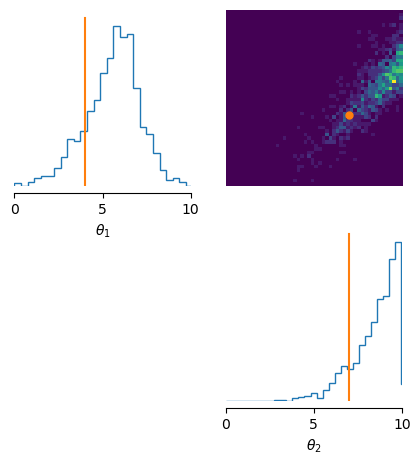

In [45]:
# plot posterior samples
fig, ax = pairplot(
    posterior_samples, limits=[[0,10], [0,10], [0,10]], figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    points=theta_true # add ground truth thetas
)

---

# NPSE
NPSE approximates the posterior distribution by learning its score function, i.e., gradient of the log-density, using the denoising score matching loss. The class of generative models is referred to as score-based generative models, with close links to diffusion models.

- Score-based generative models have been shown to scale well to very high dimensions (e.g., high-resolutions images), which is particularly useful when the parameter space (and hence, the target posterior) is high-dimensional.
- On the other hand, sampling can be slower as it involves solving many steps of the stochastic differential equation for reversing the diffusion process.

Note that only the single-round version of NPSE is implemented currently.

For more details on score-based generative models, see [Song et al., 2020](https://arxiv.org/abs/2011.13456) (in particular, Figure 1 and 2).

In [36]:
# Instantiate NPSE and append simulations
inference = NPSE(prior=prior, sde_type="ve")
inference.append_simulations(theta, x)

Note the argument `sde_type`, which defines whether the forward diffusion process has a noising schedule that is Variance Exploding (`ve`, i.e., [SMLD](https://proceedings.neurips.cc/paper/2019/hash/3001ef257407d5a371a96dcd947c7d93-Abstract.html?ref=https://githubhelp.com)), Variance Preserving (`vp`, i.e., [DDPM](https://proceedings.neurips.cc/paper/2020/hash/4c5bcfec8584af0d967f1ab10179ca4b-Abstract.html)), or sub-Variance Preserving (`subvp`) in the limit.

In [37]:
# Train the score estimator
score_estimator = inference.train()

 Neural network successfully converged after 878 epochs.

In [40]:
# Build the posterior using the trained score estimator, and sample
posterior = inference.build_posterior(score_estimator)
posterior_samples = posterior.sample((10000,), x=x_obs)

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

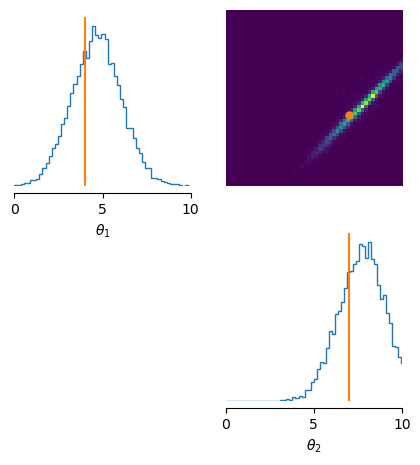

In [41]:
# plot posterior samples
fig, ax = pairplot(
    posterior_samples, limits=[[0, 10], [0, 10], [0, 10]], figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    points=theta_true # add ground truth thetas
)